In [1]:
import time
import copy
import pickle
from pathlib import Path
from typing import Sequence

import numpy as np
import pandas as pd
import sympy as smp
import matplotlib.pyplot as plt

from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

plt.rcParams.update({"font.size": 14})

In [2]:
data_dir = Path().cwd()

In [3]:
with open("Hint.pickle", "rb") as f:
    Hint = pickle.load(f)

with open("BR.pickle", "rb") as f:
    Br = pickle.load(f)

with open("H0.pickle", "rb") as f:
    Hint_values = pickle.load(f)

rabi_rates = pd.read_csv("rabi_factors.txt", delimiter=" ", header=None)

In [46]:
Hint

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                               0,                                                                                                                                                       

In [4]:
dis = Dissipator(np.shape(Hint)[0])

In [5]:
idx_ground, idx_excited = np.nonzero(Br)
gammas = smp.symbols(f"Γ0:{len(idx_ground)}", real=True)

for idx, (idg, ide) in enumerate(zip(idx_ground, idx_excited)):
    dis.add_decay(ide + 12, idg, gammas[idx])

In [6]:
dis.dissipator[:4, :4]

Matrix([
[Γ0*ρ1212(t) + Γ1*ρ1313(t) + Γ2*ρ1414(t),                                                     0,                                                      0,                                          0],
[                                      0, Γ3*ρ1212(t) + Γ4*ρ1313(t) + Γ5*ρ1414(t) + Γ6*ρ1515(t),                                                      0,                                          0],
[                                      0,                                                     0, Γ10*ρ1515(t) + Γ7*ρ1212(t) + Γ8*ρ1313(t) + Γ9*ρ1414(t),                                          0],
[                                      0,                                                     0,                                                      0, Γ11*ρ1212(t) + Γ12*ρ1414(t) + Γ13*ρ1515(t)]])

In [7]:
import re

pattern = r"from(\d+)"

energy_symbols = smp.symbols(f"E0:{np.shape(Hint)[0]}")
ham = copy.deepcopy(Hint)
ham = ham.subs(
    [
        (energy_symbol, float(energy))
        for energy_symbol, energy in zip(energy_symbols, np.diag(Hint_values).real)
    ]
)

for rabi_str, value in rabi_rates.values:
    transition_number_match = re.search(pattern, rabi_str)
    transition_number = transition_number_match.group(1)
    w = smp.Symbol(f"Ω{transition_number}")
    ham = ham.subs(smp.Symbol(rabi_str), float(value) * w)

In [8]:
dissipator = copy.deepcopy(dis.dissipator)

idx_ground, idx_excited = np.nonzero(Br)
gammas = smp.symbols(f"Γ0:{len(idx_ground)}", real=True)
for idx, (idg, ide) in enumerate(zip(idx_ground, idx_excited)):
    dissipator = dissipator.subs(gammas[idx], 2.8 * float(Br[idg, ide]))

In [9]:
start_time = time.time()
bloch = BlochEquations(
    np.shape(Hint)[0], dis.density_matrix, ham, dissipator, simplify=False
)
print(f"finished in {time.time() - start_time:.1f}s")

finished in 3.0s


In [10]:
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, dis.density_matrix, simplify=False
    )
)

In [11]:
from optical_bloch.julia_utils import OdeParameters

odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)

c:\Users\ogras\anaconda3\envs\optical-bloch-python\Lib\site-packages\juliacall\__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [12]:
from optical_bloch import julia_utils

In [13]:
from juliacall import Main as jl

julia_utils.init_julia(code)

In [14]:
ρ = np.zeros(ham.shape, dtype=complex)
for i in range(12):
    ρ[i, i] = 1 / 12

In [15]:
for par in free_parameters[:9]:
    setattr(odepars, str(par), np.random.uniform(-20, 20))

for par in free_parameters[9:]:
    setattr(odepars, str(par), 10.0)

In [16]:
problem = julia_utils.OBEProblem(odepars, ρ, (0, 100))
config = julia_utils.OBEProblemConfig(save_everystep=False)

In [17]:
sol = julia_utils.setup_solve_problem(problem, config)

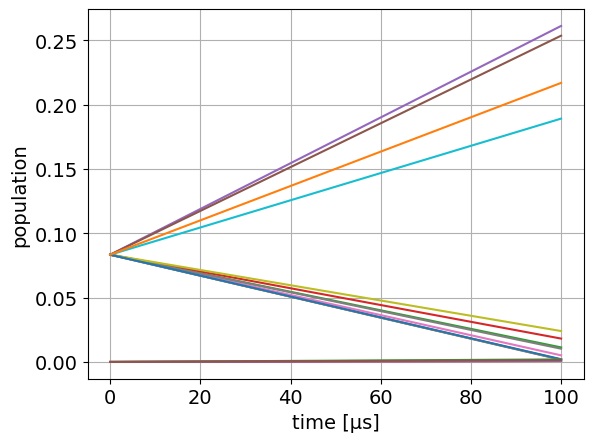

In [18]:
t = sol.t
y = np.einsum("ijj -> ij", sol.y).real

fig, ax = plt.subplots()
ax.plot(t, y)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

In [19]:
jl.seval("using BenchmarkTools")
jl.seval("@benchmark sol = solve(prob, Tsit5(), save_everystep=true)")

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 5.442 s (0.00% GC) to evaluate,
 with a memory estimate of 203.13 MiB, over 56467 allocations.

In [20]:
julia_utils.init_julia_ensemble(lindblad_function=code, nprocs=6)

In [21]:
ensemble_problem = julia_utils.OBEEnsembleProblem(
    problem,
    ["d0", "d1", "d2"],
    np.random.uniform(-20, 20, size=(3, 20)),
    combinations=False,
)

# save_idxs are the indices of the density matrix that are saved for each solution, the
# trick is that the indices are flattened with respect to the 2D density matrix
# i.e. to save diagonals for a 4x4 matrix you need to save indices 1 and 3; julia indices
# start at 1, not 0 like python. julia_utils.get_diagonal_indices_flattened returns
# the indices to save  on the diagonal
ensemble_config = julia_utils.OBEEnsembleProblemConfig(
    save_everystep=True,
    save_idxs=julia_utils.get_diagonal_indices_flattened(16, mode="julia"),
)


julia_utils.setup_ensemble_problem(odepars, ensemble_problem)

In [22]:
julia_utils.solve_problem_ensemble(ensemble_problem, ensemble_config)

In [23]:
# getting the solutions as numpy arrays requires some conversion an list comprehension
# here we loop over the number of trajectories, given by range(1, len(jl.sol) + 1)
# and over the timesteps range(len(jl.sol[idx].u))
# for some reason looping over the trajectories starts at 1, but looping over the
# timesteps starts at 0, probably because jl.sol[idx].u converts to a python object and
# then the indexing starts at 0
res = [
    np.array([np.array(jl.sol[idx].u[idu]).real for idu in range(len(jl.sol[idx].u))])
    for idx in range(1, len(jl.sol) + 1)
]
t = [np.array(jl.sol[idx].t) for idx in range(1, len(jl.sol) + 1)]

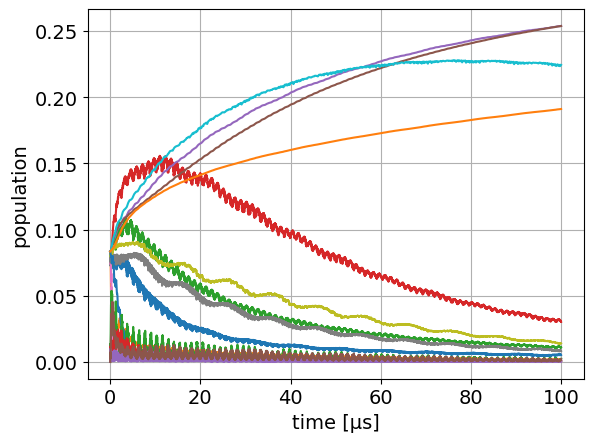

In [24]:
fig, ax = plt.subplots()
ax.plot(t[0], np.squeeze(res[0]))
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

Now looping over all possible combinations between d0, d1 and d2, e.g. the combinations configuration. This iterates over the combinations in loops, with the innermost loop d2, then d1, then d0.

In [42]:
ensemble_problem_combinations = julia_utils.OBEEnsembleProblem(
    problem=problem,
    parameters=("d0", "d1", "d2"),
    scan_values=[
        np.linspace(-10, 10, 4),
        np.linspace(-10, 10, 5),
        np.linspace(-5, 5, 3),
    ],
    combinations=True,
)
# only saving the last value of ρ[1,1]
ensemble_config_combinations = julia_utils.OBEEnsembleProblemConfig(
    save_everystep=False,
    save_start=False,
    save_idxs=[1],
)
julia_utils.setup_ensemble_problem(odepars, ensemble_problem_combinations)

In [45]:
julia_utils.solve_problem_ensemble(
    ensemble_problem_combinations, ensemble_config_combinations
)

In [27]:
# retrieving the solution
res = np.array(
    jl.seval(
        "collect(Iterators.flatten(Iterators.flatten(convert(Array, real([sol.u[idx].u for idx in 1:size(sol)[end]])))))"
    )
)

In [28]:
# different way of retrieving the solution
res = np.array(
    jl.seval("vcat(vcat(real([sol.u[idx].u for idx in 1:size(sol)[end]])...)...)")
)

In [29]:
# scan values to Ndim arrays
X, Y, Z = np.meshgrid(*ensemble_problem_combinations.scan_values, indexing="ij")

In [30]:
# reshaping the results to match the Ndim scan value arrays !!! NEED TO VERIFY IF CORRECT !!!
res_reshaped = res.reshape(
    [len(v) for v in ensemble_problem_combinations.scan_values][::-1]
).T

Text(0, 0.5, 'population')

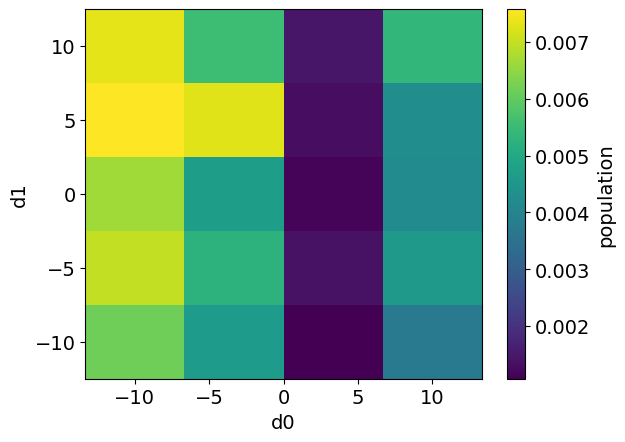

In [31]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(X[:, :, 0], Y[:, :, 0], res_reshaped[:, :, 0])
cbar = fig.colorbar(cax)

ax.set_xlabel("d0")
ax.set_ylabel("d1")
cbar.ax.set_ylabel("population")